In [121]:
from IPython.display import clear_output  # clear_output(wait=True)
import os
import re
from os.path import isfile, join

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [1052]:
VIDEO = 'cars_640'  # bridge, highway, night, highway_day, highway_night, cars_640, back_view_640, night_speed_640

FRAMES_PATH = 'frames/'
CONTOUR_FRAMES_PATH = "contour_frames/"

IN_PATH = 'videos/'
OUT_PATH = 'out_videos/frame_diff/'

VIDEO_PATH = VIDEO + '/'
VIDEO_MP4_PATH = VIDEO + '.mp4'


VIDEO_FRAMES_PATH = os.path.join(FRAMES_PATH, VIDEO_PATH)
VIDEO_CONTOUR_FRAMES_PATH = os.path.join(CONTOUR_FRAMES_PATH, VIDEO_PATH)

VIDEO_MP4_IN_PATH = os.path.join(IN_PATH, VIDEO_MP4_PATH)
VIDEO_MP4_OUT_PATH = os.path.join(OUT_PATH, VIDEO_MP4_PATH)

if not os.path.exists(VIDEO_FRAMES_PATH):
    os.makedirs(VIDEO_FRAMES_PATH)

if not os.path.exists(VIDEO_CONTOUR_FRAMES_PATH):
    os.makedirs(VIDEO_CONTOUR_FRAMES_PATH)

In [1053]:
# CAP_PROP_POS_MSEC      Current position of the video file in milliseconds or video capture timestamp.
# CAP_PROP_POS_FRAMES    0-based index of the frame to be decoded/captured next.
# CAP_PROP_POS_AVI_RATIO Relative position of the video file: 0 - start of the film, 1 - end of the film.
# CAP_PROP_FRAME_WIDTH   Width of the frames in the video stream.
# CAP_PROP_FRAME_HEIGHT  Height of the frames in the video stream.
# CAP_PROP_FPS           Frame rate.
# CAP_PROP_FOURCC        4-character code of codec.
# CAP_PROP_FRAME_COUNT   Number of frames in the video file.
# CAP_PROP_FORMAT        Format of the Mat objects returned by retrieve() .
# CAP_PROP_MODE          Backend-specific value indicating the current capture mode.
# CAP_PROP_BRIGHTNESS    Brightness of the image (only for cameras).
# CAP_PROP_CONTRAST      Contrast of the image (only for cameras).
# CAP_PROP_SATURATION    Saturation of the image (only for cameras).
# CAP_PROP_HUE           Hue of the image (only for cameras).
# CAP_PROP_GAIN          Gain of the image (only for cameras).
# CAP_PROP_EXPOSURE      Exposure (only for cameras).
# CAP_PROP_CONVERT_RGB   Boolean flags indicating whether images should be converted to RGB.
# CAP_PROP_WHITE_BALANCE Currently not supported
# CAP_PROP_RECTIFICATION Rectification flag for stereo cameras (note: only supported by DC1394 v 2.x backend currently)


def vidcap_describe(vidcap):
    print(f'Width: \t\t{round(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))}')
    print(f'Height: \t{round(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))}')
    print(f'FPS: \t\t{round(vidcap.get(cv2.CAP_PROP_FPS))}')
    print(f'Frames count:\t{round(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))}')

In [1056]:
# video to frames
vidcap = cv2.VideoCapture(VIDEO_MP4_IN_PATH)

vidcap_w = round(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))
vidcap_h = round(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))

vidcap_describe(vidcap)

Width: 		640
Height: 	360
FPS: 		25
Frames count:	1501


## Ekstrakcja i zapis klatek wejściowego strumienia wideo

In [1057]:
success, image = vidcap.read()

count = 0
while success:
    # save frame as PNG file
    cv2.imwrite('%s%d.png' % (VIDEO_FRAMES_PATH, count), image)
    success, image = vidcap.read()

    clear_output(wait=True)
    print(f'Read {count} frame: {success}')

    count += 1

Read 1500 frame: False


## Wczytanie klatek do pamięci

In [1058]:
# get file names of the frames
col_frames = os.listdir(VIDEO_FRAMES_PATH)

# sort file names
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# list to store the frames
col_images = []
for i in tqdm(col_frames):
    # read the frames
    img = cv2.imread(VIDEO_FRAMES_PATH + i)
    # append the frames to the list
    col_images.append(img)

100%|██████████| 1501/1501 [00:10<00:00, 142.15it/s]


## Odnalezienie 2 kolejnych klatek do eksploracji

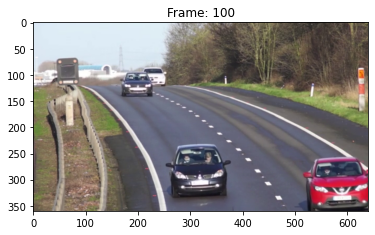

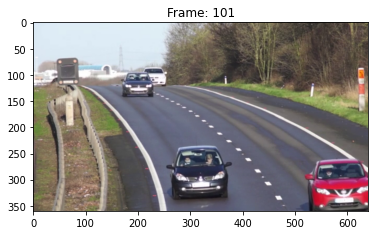

In [1062]:
# plot i and i+1 frame
fr = 100  # 15, 325, 100 - cars_640, 125 - back_view_640
for frame in [fr, fr+1]:
    plt.imshow(cv2.cvtColor(col_images[frame], cv2.COLOR_BGR2RGB))
    plt.title(f'Frame: {str(frame)}')
    plt.show()

## Konwersja klatek do skali szarości oraz różnicowanie klatek

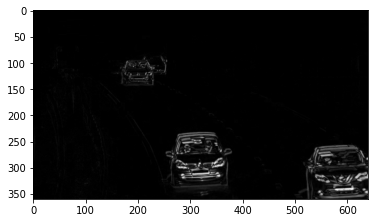

In [1063]:
# convert the frames to grayscale
grayA = cv2.cvtColor(col_images[fr], cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(col_images[fr+1], cv2.COLOR_BGR2GRAY)

# plot the image after frame differencing
plt.imshow(cv2.absdiff(grayB, grayA), cmap='gray')
plt.show()

## Binaryzacja różnicowanych klatek - progowanie

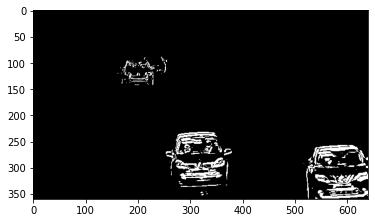

In [1071]:
if VIDEO == 'highway':
    THRESHHOLD = 30
elif VIDEO == 'night':
    THRESHHOLD = 80
elif VIDEO == 'bridge':
    THRESHHOLD = 30
elif VIDEO == 'highway_day':
    THRESHHOLD = 75
elif VIDEO == 'cars_640':
    THRESHHOLD = 35  # 35
elif VIDEO == 'back_view_640':
    THRESHHOLD = 20  # 20, ad: 11, -20
elif VIDEO == 'night_speed_640':
    THRESHHOLD = 80

diff_image = cv2.absdiff(grayB, grayA)

# perform image thresholding
ret, thresh = cv2.threshold(diff_image, THRESHHOLD, 255, cv2.THRESH_BINARY)
# thresh = cv2.adaptiveThreshold(diff_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, -20) 
# thresh = cv2.adaptiveThreshold(diff_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 17, -20)

# plot image after thresholding
plt.imshow(thresh, cmap='gray')
plt.show()

## Dylatacja różnicowanych klatek

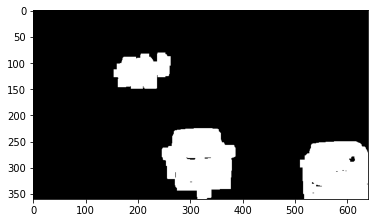

In [1076]:
if VIDEO == 'highway':
    KERNEL_SIZE = 3
    DILATE_ITER = 1
elif VIDEO == 'night':
    KERNEL_SIZE = 31
    DILATE_ITER = 1
elif VIDEO == 'bridge':
    KERNEL_SIZE = 3
    DILATE_ITER = 1
elif VIDEO == 'highway_day':
    KERNEL_SIZE = 50
    DILATE_ITER = 1
elif VIDEO == 'cars_640':
    KERNEL_SIZE = 15 # 15 i:1 - better for stadard threshhold
    DILATE_ITER = 1
elif VIDEO == 'back_view_640':
    KERNEL_SIZE = 13 # 7, 9 - better for stadard threshhold, 13 - ok for ADAPTIVE_THRESH_MEAN_C
    DILATE_ITER = 1
elif VIDEO == 'night_speed_640':
    KERNEL_SIZE = 9 # 7

# apply image dilation
kernel = np.ones((KERNEL_SIZE,KERNEL_SIZE), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=DILATE_ITER)

# plot dilated image
plt.imshow(dilated, cmap='gray')
plt.show()

## Ustalenie strefy detekcji

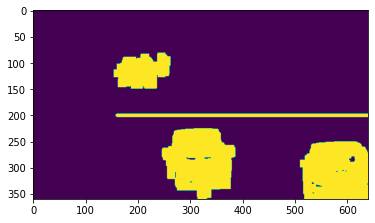

In [1077]:
if VIDEO == 'highway':
    DETECTION_ZONE = [(0,80), (256,80)]
elif VIDEO == 'night':
    DETECTION_ZONE = [(0,500), (1280,500)]
elif VIDEO == 'bridge':
    DETECTION_ZONE = [(0,80), (256,80)]
elif VIDEO == 'highway_day':
    DETECTION_ZONE = [(0,600), (1376,600)]
elif VIDEO == 'cars_640':
    DETECTION_ZONE = [(160,200), (640,200)]
elif VIDEO == 'back_view_640':
    DETECTION_ZONE = [(0,240), (500,240)]
elif VIDEO == 'back_view_640':
    DETECTION_ZONE = [(0,240), (500,240)]

# plot vehicle detection zone
cv2.line(dilated, DETECTION_ZONE[0], DETECTION_ZONE[1], (255,1,1), 5)
plt.imshow(dilated)
# v2.line(dilated, DETECTION_ZONE[0], DETECTION_ZONE[1], (255,1,1), 5)
plt.show()

## Odnajdywanie konturów obiektów znajdujących się w polu detekcji

In [1078]:
# find contours
# contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

In [1082]:
valid_cntrs = []

for i, cntr in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cntr)
    if VIDEO == 'highway':
        if (x <= 220) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
            valid_cntrs.append(cntr)
    elif VIDEO == 'night':
        if (x >= 600) & (y >= 500) & (cv2.contourArea(cntr) >= 25):
            valid_cntrs.append(cntr)
    elif VIDEO == 'bridge':
        if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
            valid_cntrs.append(cntr)
    elif VIDEO == 'highway_day':
        if (y >= 600) & (cv2.contourArea(cntr) >= 500):
            valid_cntrs.append(cntr)
    elif VIDEO == 'cars_640':
        if (x >= 160) & (y >= 200) & (cv2.contourArea(cntr) >= 2800):
            valid_cntrs.append(cntr)
    elif VIDEO == 'back_view_640':
        if (x <= 500) & (y >= 240) & (cv2.contourArea(cntr) >= 1000):
            valid_cntrs.append(cntr)


# count of discovered contours        
len(valid_cntrs)

2

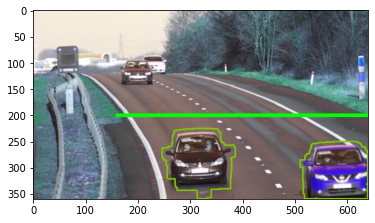

In [1083]:
dmy = col_images[fr].copy()

cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)
cv2.line(dmy, DETECTION_ZONE[0], DETECTION_ZONE[1], (0,255,0), 5)
plt.imshow(dmy)
plt.show()

## Wykonanie powyższych proków na całym zbiorze klatek + zliczanie obiektów

In [1084]:
# kernel for image dilation
kernel = np.ones((KERNEL_SIZE,KERNEL_SIZE),np.uint8)  # hishway - 4 here

# font style
font = cv2.FONT_HERSHEY_SIMPLEX

# directory to save the ouput frames
pathIn = VIDEO_CONTOUR_FRAMES_PATH

#prev_cnt_cntrs = None
cnt_cntrs = 0 # None
overall_cnt = 0

for i in tqdm(range(len(col_images)-1)):
    
    # frame differencing
    grayA = cv2.cvtColor(col_images[i], cv2.COLOR_BGR2GRAY)
    grayB = cv2.cvtColor(col_images[i+1], cv2.COLOR_BGR2GRAY)
    diff_image = cv2.absdiff(grayB, grayA)
    
    # image thresholding
    ret, thresh = cv2.threshold(diff_image, THRESHHOLD, 255, cv2.THRESH_BINARY)
    # thresh = cv2.adaptiveThreshold(diff_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, -20)
    
    # image dilation
    dilated = cv2.dilate(thresh, kernel, iterations=DILATE_ITER)
    
    # find contours
    contours, hierarchy = cv2.findContours(dilated.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # shortlist contours appearing in the detection zone
    prev_cnt_cntrs = cnt_cntrs

    valid_cntrs = []
    for cntr in contours:
        x, y, w, h = cv2.boundingRect(cntr)
        if VIDEO == 'highway':
            if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
                if (y >= 90) & (cv2.contourArea(cntr) < 40):
                    break
                valid_cntrs.append(cntr)
        elif VIDEO == 'night':
            if (x >= 600) & (y >= 500) & (cv2.contourArea(cntr) >= 25):
                valid_cntrs.append(cntr)
        elif VIDEO == 'bridge':
            if (x <= 200) & (y >= 80) & (cv2.contourArea(cntr) >= 25):
                valid_cntrs.append(cntr)
        elif VIDEO == 'highway_day':
            if (y >= 600) & (cv2.contourArea(cntr) >= 1000):
                valid_cntrs.append(cntr)
        elif VIDEO == 'cars_640':
            if (x >= 160) & (y >= 200) & (cv2.contourArea(cntr) >= 2800):
                valid_cntrs.append(cntr)
        elif VIDEO == 'back_view_640':
            if (x <= 500) & (y >= 240) & (cv2.contourArea(cntr) >= 1000):
                valid_cntrs.append(cntr)
            
    # add contours to original frames
    dmy = col_images[i].copy()
    cv2.drawContours(dmy, valid_cntrs, -1, (127,200,0), 2)

    cnt_cntrs = len(valid_cntrs)
    #if prev_cnt_cntrs:
    if prev_cnt_cntrs < cnt_cntrs:
        overall_cnt += abs(prev_cnt_cntrs-cnt_cntrs)
    
    cv2.putText(dmy, "VEHICLES DETECTED NOW: " + str(cnt_cntrs), (30,45), font, 0.6, (0,0,180), 2)
    cv2.putText(dmy, "VEHICLES DETECTED OVERALL: " + str(overall_cnt), (30,75), font, 0.6, (0,0,180), 2)
    cv2.line(dmy, DETECTION_ZONE[0], DETECTION_ZONE[1], (0, 255, 0))  # (100, 255, 255)
    
    cv2.imwrite(pathIn+str(i)+'.png', dmy)

100%|██████████| 1500/1500 [00:17<00:00, 86.55it/s]


## Zapis przetworzonych klatek

In [1085]:
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

files.sort(key=lambda f: int(re.sub('\D', '', f)))

for i in tqdm(range(len(files))):
    filename=pathIn + files[i]
    
    #read frames
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    
    #inserting the frames into an image array
    frame_array.append(img)

100%|██████████| 1500/1500 [00:10<00:00, 141.02it/s]


## Złączenie ich do wyjściowego strumienia wideo

In [1086]:
# specify video name
pathOut = VIDEO_MP4_OUT_PATH

# specify frames per second
fps = 25.0  # 14.0 30.0 25.0

In [1087]:
out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in tqdm(range(len(frame_array))):
    # writing to a image array
    out.write(frame_array[i])

out.release()

100%|██████████| 1500/1500 [00:02<00:00, 561.59it/s]
